In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from initialize_model import *
from functions.helpers import organise_data, confidence_interval
from model import *
from matplotlib import style

In [2]:
style.use('seaborn-ticks')

# Run the model

Simple parameters.

In [26]:
parameters = {'trader_sample_size': 10,
              'n_traders': 50,
              'init_stocks': 41,
              'ticks': 50,
              'fundamental_value': 90.0,
              'std_fundamental': 0.0361,
              'base_risk_aversion': 0.7,
              'spread_max': 1.0,
              'horizon': 50,
              'money_multiplier': 1.5,
              'std_noise': 0.0361,
              'w_random': 1.0,
              'mean_reversion': 0.0,
              'fundamentalist_horizon_multiplier': 1.0,
              'strat_share_chartists': 0.0,
              'mutation_intensity': 0.0,
              'average_learning_ability': 0.0,
              'verbose': False}

# Run model

First determine the amount of simulation runs. At every run a different random seed will be used.

In [27]:
NRUNS = 10

All the data output data of the model will be stored in a list of traders and list of orderbooks per seed. 

In [28]:
trdrs = []
orbs = []
rl_agents = []
for seed in range(NRUNS): 
    traders, orderbook, rl_agent = init_objects(parameters, seed)
    traders, orderbook, rl_agent = seller_model(traders, orderbook, rl_agent, parameters, seed)
    trdrs.append(traders)
    orbs.append(orderbook)
    rl_agents.append(rl_agent)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9


Store the data in dataframes

In [29]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=0)

# Model generated price & volume

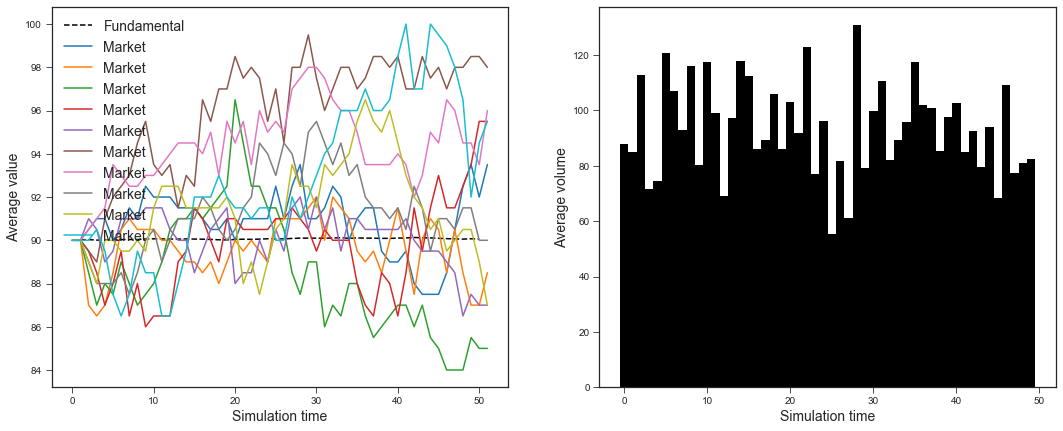

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='Fundamental')
ax1.plot(mc_prices.index, mc_prices, label='Market')
ax1.legend(loc='best', fontsize='14')

ax1.set_ylabel('Average value', fontsize='14')

ax2.bar(mc_volume.index, mc_volume.mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Average volume', fontsize='14')

for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    

#fig.savefig('baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Model generated returns per agent

In [18]:
wealth_starts = []
wealth_ends = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    for t in range(parameters['ticks']):
        #print(t)
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))

In [19]:
av_profits = np.zeros(len(profits[0]))

for i in range(len(profits)):
    av_profits += profits[i]
    
av_profits = av_profits / float(len(profits))

The graph below depicts returns of individual agents. Ideally the RL agent will at some point in time outperform all other agents.

Text(0.5, 0, 'Agent number')

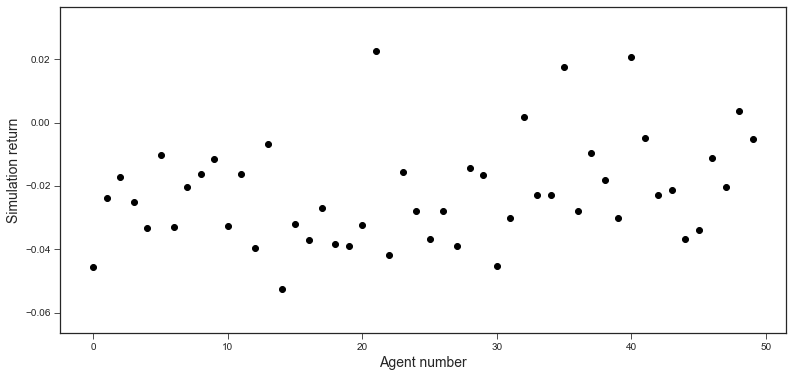

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(13,6))

ax1.scatter(range(len(av_profits)), av_profits, color='black')

ax1.set_ylabel('Simulation return', fontsize='14')

ax1.set_xlabel('Agent number', fontsize='14')